In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute, circuit, extensions
import matplotlib.pyplot as plt
import math
import numpy as np
from functools import reduce
import pandas as pd
from sklearn.model_selection import train_test_split
from qiskit.visualization import plot_bloch_multivector
from qiskit.quantum_info import Statevector
from datetime import datetime
from qiskit.aqua.components.optimizers import COBYLA, ADAM, AQGD, NFT

In [2]:
def normalize(l):
    normalization_factor = math.sqrt(sum([i ** 2 for i in l]))
    return [i / normalization_factor for i in l]

def init_gate(init_states, label=None, size=None):
    if not size:
        size = math.ceil(math.log2(len(init_states)))
    state_vector = normalize(init_states) + [0] * ((2 ** size) - len(init_states))
    #I know this is way ugly, but it's the easiest way to actualy turn initialize() into a gate
    return extensions.Initialize(state_vector).gates_to_uncompute().inverse().to_gate(label=label if label else None)

In [3]:
def x_indices(i, bits):
    indices = []
    for j in range(bits):
        bit = (i >> j) & 1
        if not bit:
            indices.append(j)
    return indices

In [36]:
def construct_oracle(data, labels):
#     print(len(data), len(labels))
    # gate = init_gate([0,2,10], "psi_0")
    data_bits = math.ceil(math.log2(data.shape[1]))
    counting_bits = math.ceil(math.log2(data.shape[0]))
#     print(len(data), data.shape[0])
    q = QuantumRegister(data_bits + counting_bits + 1)
    qc = QuantumCircuit(q)

#     data = [[x,x*2,x**2] for x in range(1, 16)]
    qc.h(q[data_bits + 1:])
    for i in range(len(data)):
        x_i = [data_bits + 1 + x_i for x_i in x_indices(i,counting_bits)]
        if len(x_i) > 0:
            qc.x(x_i)
        gate = init_gate(data[i], f"psi_{i}", data_bits).control(counting_bits)
        qc.append(gate, q[data_bits + 1:] + q[:data_bits])
        if labels[i] == 1:
            x_gate = circuit.library.XGate().control(counting_bits)
            qc.append(x_gate, q[data_bits + 1:] + [q[data_bits]])

        if len(x_i) > 0:
            qc.x(x_i)
    return qc, data_bits, counting_bits

In [5]:
def destructive_swap(n):
    q = QuantumRegister(n * 2)
    circuit = QuantumCircuit(q)
    
    for i in range(n):
        circuit.cx(i, n+i)
        circuit.h(i)
#     print(circuit)
    return circuit.to_gate(label="destructive_swap")


In [6]:
def interpret_des_swap(counts):
    successes = 0
    for k in counts:
        #success if and of measurement has even parity, that's what the paper said
        success = reduce(lambda b, p: (p == ('1', '1')) ^ b , zip(list(k[:len(k)//2]), list(k[len(k)//2:])), True)
#         print(k, success)
#         success = k.count('1') % 2 == 0
        if success:
            successes += counts[k]
    if sum(counts.values()) == 0:
        return 0
    return  2 * (successes / sum(counts.values())) - 1

In [228]:
def construct_classifier(data, labels, generator = None):
    input_size = math.ceil(math.log2(data.shape[1]))
    oracle, data_bits, counting_bits = construct_oracle(data, labels)
    print(oracle)
    if generator:
        oracle = generator.to_gate(label="generator")
    else:
        oracle = oracle.to_gate(label="oracle")
    q = QuantumRegister(input_size + data_bits + counting_bits + 1)
    c = ClassicalRegister(input_size * 2 + 1)
    qc = QuantumCircuit(q, c)
    
    qc.append(oracle, q[input_size:])
#     print(input_size)
    qc.append(destructive_swap(input_size), q[:input_size] + q[input_size:input_size+input_size])
    for i in range(input_size * 2 + 1):
        qc.measure(i,i)
    return qc


In [8]:
df = pd.read_csv("bezdekIris.data", header=None)

In [9]:
df[4] = [0 if p == "Iris-setosa" else 1 if p == "Iris-virginica" else 2 for p in df[4]]
df = df[df[4] != 2]

In [173]:
train, test = train_test_split(df, test_size=0.36)
data = train[[0,1]].to_numpy()
labels = train[4].to_numpy()
label0 = -1
n_data_points = 2

n_label0s = n_data_points / 2
n_label1s = n_data_points / 2

label0s = []
label1s = []

for i in range(len(labels)):
    if labels[i] == 0 and n_label0s > 0:
        n_label0s -= 1
        label0s.append(i)
        
    if labels[i] == 1 and n_label1s > 0:
        n_label1s -= 1
        label1s.append(i)
        
    if n_label0s < 1 and n_label1s < 1:
        break

idx = label0s + label1s
        
data = data[idx]
labels = labels[idx]

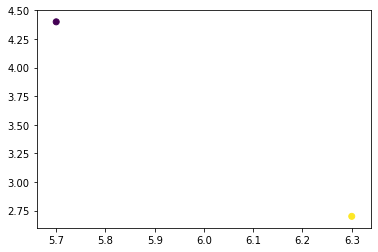

In [174]:
plt.scatter(x=data[:, 0], y=data[:, 1], c=labels)
plt.show()

In [175]:
q = QuantumRegister(1)
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)

inp_gate = init_gate([6.5, 3], label="input", size=1)

qc.append(inp_gate, q[0:1])

state = Statevector.from_instruction(qc)
# plot_bloch_multivector(state, title="New Bloch Multivector", reverse_bits=False)

In [176]:
q = QuantumRegister(1)
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)

inp_gate = init_gate([5, 3.5], label="input", size=1)

qc.append(inp_gate, q[0:1])

state = Statevector.from_instruction(qc)
# plot_bloch_multivector(state, title="New Bloch Multivector", reverse_bits=False)

In [226]:
# data = np.ones((20,4))
# data = np.array([np.array([1,2,0,4]) for i in range(20)])


qc_classifier = construct_classifier(data, labels)


                     ┌───────┐     ┌───────┐     
q912288_0: ──────────┤ psi_0 ├─────┤ psi_1 ├─────
                     └───┬───┘     └───┬───┘┌───┐
q912288_1: ──────────────┼─────────────┼────┤ X ├
           ┌───┐┌───┐    │    ┌───┐    │    └─┬─┘
q912288_2: ┤ H ├┤ X ├────■────┤ X ├────■──────■──
           └───┘└───┘         └───┘              


In [227]:
def classify(inp, generator=None):
    num_qubits = qc_classifier.num_qubits

    data_size = math.ceil(math.log2(data.shape[1]))

    num_cbits = data_size * 2 + 1


    q = QuantumRegister(num_qubits)
    c = ClassicalRegister(num_cbits)
    qc = QuantumCircuit(q, c)

    # inp_gate = init_gate([1,2,0,4])
    inp_gate = init_gate(inp, label="input", size=data_size)


    qc.append(inp_gate, q[0:1])
    qc = qc.compose(construct_classifier(data, labels, generator))
    print(qc)
    backend = Aer.get_backend('qasm_simulator')
    job = execute(backend=backend, experiments=qc, shots=500)
    result = job.result()

    counts = result.get_counts()
    counts_0 = {key[1:]:value for key, value in counts.items() if key[0] == '0'}
    counts_1 = {key[1:]:value for key, value in counts.items() if key[0] == '1'}

    return (interpret_des_swap(counts_0), interpret_des_swap(counts_1))

In [225]:
label_names = [0,1]
correct = 0
count = 0
for index, row in test.iterrows():
    label = row[4]
    results = classify(row[[0,1]].tolist())
    cor = False
    if results[0] > results[1] and label == labels[0]:
        correct += 1
        cor = True
    elif results[0] < results[1] and label == labels[1]:
        correct += 1
        cor = True
    count += 1
    print(f"features:({row[0]}, {row[1]}), label:{label}, result:{label_names[0]}:{results[0]}, {label_names[1]}:{results[1]}, {'correct' if cor else 'incorrect'}, accuracy:{correct / count}")

print(correct / len(test))


            ┌───────┐ ┌───────────────────┐┌─┐   
q911100_0: ─┤ input ├─┤0                  ├┤M├───
           ┌┴───────┴┐│  destructive_swap │└╥┘┌─┐
q911100_1: ┤0        ├┤1                  ├─╫─┤M├
           │         │└────────┬─┬────────┘ ║ └╥┘
q911100_2: ┤1 oracle ├─────────┤M├──────────╫──╫─
           │         │         └╥┘          ║  ║ 
q911100_3: ┤2        ├──────────╫───────────╫──╫─
           └─────────┘          ║           ║  ║ 
 c16501: 3/═════════════════════╩═══════════╩══╩═
                                2           0  1 
{'011': 9, '000': 127, '010': 91, '101': 63, '001': 29, '110': 72, '100': 109}
features:(7.7, 3.0), label:1.0, result:0:0.9296875, 1:1.0, correct, accuracy:1.0
            ┌───────┐ ┌───────────────────┐┌─┐   
q911133_0: ─┤ input ├─┤0                  ├┤M├───
           ┌┴───────┴┐│  destructive_swap │└╥┘┌─┐
q911133_1: ┤0        ├┤1                  ├─╫─┤M├
           │         │└────────┬─┬────────┘ ║ └╥┘
q911133_2: ┤1 oracle ├─────────┤M├──────

{'001': 13, '010': 119, '110': 93, '100': 121, '101': 32, '000': 113, '111': 9}
features:(5.0, 3.6), label:0.0, result:0:1.0, 1:0.9294117647058824, correct, accuracy:0.95
            ┌───────┐ ┌───────────────────┐┌─┐   
q911760_0: ─┤ input ├─┤0                  ├┤M├───
           ┌┴───────┴┐│  destructive_swap │└╥┘┌─┐
q911760_1: ┤0        ├┤1                  ├─╫─┤M├
           │         │└────────┬─┬────────┘ ║ └╥┘
q911760_2: ┤1 oracle ├─────────┤M├──────────╫──╫─
           │         │         └╥┘          ║  ║ 
q911760_3: ┤2        ├──────────╫───────────╫──╫─
           └─────────┘          ║           ║  ║ 
 c16521: 3/═════════════════════╩═══════════╩══╩═
                                2           0  1 
{'010': 110, '111': 4, '000': 133, '110': 82, '100': 128, '101': 30, '001': 13}
features:(5.4, 3.7), label:0.0, result:0:1.0, 1:0.9672131147540983, correct, accuracy:0.9523809523809523
            ┌───────┐ ┌───────────────────┐┌─┐   
q911793_0: ─┤ input ├─┤0                  ├┤

In [180]:
num_qubits = qc_classifier.num_qubits

data_size = math.ceil(math.log2(data.shape[1]))

num_cbits = data_size * 2 + 1


q = QuantumRegister(num_qubits)
c = ClassicalRegister(num_cbits)
qc = QuantumCircuit(q, c)

# inp_gate = init_gate([1,2,0,4])
inp_gate = init_gate([1,2], label="input", size=data_size)

qc.append(inp_gate, q[0:1])
qc = qc.compose(qc_classifier)
print(qc)
backend = Aer.get_backend('qasm_simulator')
job = execute(backend=backend, experiments=qc, shots=2000)
result = job.result()

# print(result.get_counts())
counts = result.get_counts()

counts_0 = {key[1:]:value for key, value in counts.items() if key[0] == '0'}
counts_1 = {key[1:]:value for key, value in counts.items() if key[0] == '1'}

print(counts)
print(interpret_des_swap(counts_0))
print(interpret_des_swap(counts_1))

            ┌───────┐ ┌───────────────────┐┌─┐   
q637973_0: ─┤ input ├─┤0                  ├┤M├───
           ┌┴───────┴┐│  destructive_swap │└╥┘┌─┐
q637973_1: ┤0        ├┤1                  ├─╫─┤M├
           │         │└────────┬─┬────────┘ ║ └╥┘
q637973_2: ┤1 oracle ├─────────┤M├──────────╫──╫─
           │         │         └╥┘          ║  ║ 
q637973_3: ┤2        ├──────────╫───────────╫──╫─
           └─────────┘          ║           ║  ║ 
 c10227: 3/═════════════════════╩═══════════╩══╩═
                                2           0  1 
{'101': 2, '010': 488, '110': 476, '100': 306, '111': 227, '000': 409, '011': 69, '001': 23}
0.8604651162790697
0.5509396636993076


In [182]:
# n_features gets boiled down to amount of qubits necessary for it to work TODO: Change n_labels to do the same
def build_variational_circuit(depth, generator_width, n_labels, params=None, measurement=False):
    # TODO: Add y and z rotations
    n_qubits = generator_width + n_labels
    
    def seriessum(n):
        n_sum = 0
        for i in range(n):
            n_sum += i
        return n_sum
    
    n_rot_qubits_per_layer = n_qubits * 2
    n_qubits_per_layer = n_rot_qubits_per_layer + seriessum(n_qubits)
    n_entangle_qubits_per_layer = seriessum(n_qubits)
    
#     print(params)
    
    if params is None:
        params = np.random.rand(depth * (n_rot_qubits_per_layer + n_entangle_qubits_per_layer)) * math.pi
    
#     print(params)
    
#     print(len(params))
    
    q = QuantumRegister(n_qubits)
    if measurement:
        c = ClassicalRegister(n_qubits)
        qc = QuantumCircuit(q, c)
    else:
        qc = QuantumCircuit(q)
        
    
    # Dynamically add rx rotation and rxx entanglement gates
    for i in range(depth):
        for j in range(n_qubits):
#             print(i * depth, j)
#             print(i * n_qubits_per_layer, j, (i * n_qubits_per_layer) + j)
            qc.rx(params[i * n_qubits_per_layer + j*2], j)
            qc.rz(params[i * n_qubits_per_layer + j*2 + 1], j)
        next_param = 0
        for j in range(n_qubits):
#             print(i * n_qubits_per_layer, j, (i * n_qubits_per_layer) + j)
            for k in range(n_qubits):
                if j == k or j < k:
                    continue
#                 print(i * n_qubits_per_layer + n_rot_qubits_per_layer + next_param)
#                 print(i * n_rot_qubits_per_layer + j + next_param + n_rot_qubits_per_layer)
                qc.rxx(params[i * n_qubits_per_layer + n_rot_qubits_per_layer + next_param], j, k)
                next_param += 1
        
        if measurement:
            qc.barrier()
    
    if measurement:
        for i in range(n_qubits):
            qc.measure(i, i)
            
    return qc
      
build_variational_circuit(8, 2, 1, measurement=True).draw()

┌─────────────┐ ┌────────────┐┌───────────────┐┌───────────────┐»
q638007_0: ┤ RX(0.21021) ├─┤ RZ(2.1804) ├┤1              ├┤1              ├»
           └┬────────────┤┌┴────────────┤│  RXX(0.70863) ││               │»
q638007_1: ─┤ RX(2.6542) ├┤ RZ(0.22662) ├┤0              ├┤  RXX(0.85167) ├»
           ┌┴────────────┤└┬────────────┤└───────────────┘│               │»
q638007_2: ┤ RX(0.40795) ├─┤ RZ(2.2693) ├─────────────────┤0              ├»
           └─────────────┘ └────────────┘                 └───────────────┘»
 c10229: 3/════════════════════════════════════════════════════════════════»
                                                                           »
«                            ░ ┌─────────────┐ ┌─────────────┐┌──────────────┐»
«q638007_0: ─────────────────░─┤ RX(0.45872) ├─┤ RZ(0.20305) ├┤1             ├»
«           ┌──────────────┐ ░ ├─────────────┴┐└┬───────────┬┘│  RXX(2.6769) │»
«q638007_1: ┤1             ├─░─┤ RX(0.047999) ├─┤ RZ(2.468) ├─┤0             ├»
«           │  RXX(2.3955) │ ░ └┬────────────┬┘ ├───────────┴┐└──────────────┘»
«q638007_2: ┤0             ├─░──┤ RX(2.4851) ├──┤ RZ(2.2602) ├────────────────»
«           └──────────────┘ ░  └────────────┘  └────────────┘                »
« c10229: 3/══════════════════════════════════════════════════════════════════»
«                                                                             »
«           ┌───────────────┐                 ░ ┌─────────────┐ ┌────────────┐»
«q638007_0: ┤1              ├─────────────────░─┤ RX(0.69631) ├─┤ RZ(2.0348) ├»
«           │               │┌──────────────┐ ░ └┬────────────┤┌┴────────────┤»
«q638007_1: ┤  RXX(0.87285) ├┤1             ├─░──┤ RX(1.8586) ├┤ RZ(0.17826) ├»
«           │               ││  RXX(2.6498) │ ░ ┌┴────────────┤└┬────────────┤»
«q638007_2: ┤0              ├┤0             ├─░─┤ RX(0.92084) ├─┤ RZ(2.4455) ├»
«           └───────────────┘└──────────────┘ ░ └─────────────┘ └────────────┘»
« c10229: 3/══════════════════════════════════════════════════════════════════»
«                                                                             »
«           ┌──────────────┐┌────────────────┐                  ░ »
«q638007_0: ┤1             ├┤1               ├──────────────────░─»
«           │  RXX(2.8025) ││                │┌───────────────┐ ░ »
«q638007_1: ┤0             ├┤  RXX(0.061362) ├┤1              ├─░─»
«           └──────────────┘│                ││  RXX(0.58898) │ ░ »
«q638007_2: ────────────────┤0               ├┤0              ├─░─»
«                           └────────────────┘└───────────────┘ ░ »
« c10229: 3/══════════════════════════════════════════════════════»
«                                                                 »
«            ┌────────────┐┌─────────────┐ ┌───────────────┐┌──────────────┐»
«q638007_0: ─┤ RX(2.8681) ├┤ RZ(0.56789) ├─┤1              ├┤1             ├»
«           ┌┴────────────┤└┬────────────┤ │  RXX(0.83037) ││              │»
«q638007_1: ┤ RX(0.20147) ├─┤ RZ(1.7989) ├─┤0              ├┤  RXX(1.5666) ├»
«           ├─────────────┤┌┴────────────┴┐└───────────────┘│              │»
«q638007_2: ┤ RX(0.47083) ├┤ RZ(0.066449) ├─────────────────┤0             ├»
«           └─────────────┘└──────────────┘                 └──────────────┘»
« c10229: 3/════════════════════════════════════════════════════════════════»
«                                                                           »
«                            ░ ┌─────────────┐┌────────────┐┌──────────────┐»
«q638007_0: ─────────────────░─┤ RX(0.14677) ├┤ RZ(1.3106) ├┤1             ├»
«           ┌──────────────┐ ░ └┬────────────┤├────────────┤│  RXX(2.2451) │»
«q638007_1: ┤1             ├─░──┤ RX(1.8515) ├┤ RZ(1.0783) ├┤0             ├»
«           │  RXX(1.7576) │ ░  ├────────────┤├────────────┤└──────────────┘»
«q638007_2: ┤0             ├─░──┤ RX(2.8919) ├┤ RZ(1.8029) ├────────────────»
«           └──────────────┘ ░  └────────────┘└────────────┘                »
« c10229: 3/══════

In [219]:
def construct_generator_classifier(depth, n_features, n_labels, inp, params, oracle=False):
    input_size = math.ceil(math.log2(data.shape[1]))
#     oracle, data_bits, counting_bits = construct_oracle(data, labels)
    if oracle:
        variational_oracle,_,_ = construct_oracle(data, labels)
        variational_oracle_gate = variational_oracle.to_gate(label="oracle")
    else:
        variational_oracle = build_variational_circuit(depth, n_features, n_labels)
        variational_oracle_gate = variational_oracle.to_gate(label="variational_oracle")
    q = QuantumRegister(input_size + variational_oracle.num_qubits + 1)
    c = ClassicalRegister(2)
    qc = QuantumCircuit(q, c)
#     print(input_size)

    inp_gate = init_gate(inp, label="input", size=input_size)
    
    swap_test_ancilla = q[0:1]
    inp_qubits = q[1:input_size + 1]
    oracle_data_qubits = q[input_size + 1:input_size * 2 + 1]
    label_qubit = q[input_size * 2 + 1: input_size * 2 + 2]
    counting_qubits = q[input_size * 2 + 2:]

    qc.append(inp_gate, inp_qubits)
    qc.append(variational_oracle_gate, oracle_data_qubits + label_qubit + counting_qubits)
    qc.append(swap(input_size), swap_test_ancilla + inp_qubits + oracle_data_qubits)
    qc.measure(swap_test_ancilla, 0)
    qc.measure(label_qubit, 1)

    return qc

# params = [1, 1, 1, 1, 1, 1, 1, 1, 1]
# construct_generator_classifier([1, 2], params).draw()

In [184]:
def swap(n):
    q = QuantumRegister(n * 2 + 1)
    circuit = QuantumCircuit(q)
    circuit.h(q[0])
    
    for i in range(0, n):
        circuit.cswap(0, 1 + i, 1 + n+i)
    circuit.h(q[0])
#     print(circuit)
    return circuit.to_gate(label="swap")
swap(2)

In [185]:
def build_gan_stack(depth, n_features, n_labels, params=None):
    oracle, n_data_qubits, n_counting_qubits = construct_oracle(data, labels)
    generator = build_variational_circuit(depth, n_features, n_labels, params=params)
    
    oracle_gate = oracle.to_gate(label="oracle")
    generator_gate = generator.to_gate(label="generator")
    
    n_qubits = n_counting_qubits + n_data_qubits + generator.num_qubits + 2
    
    q = QuantumRegister(n_qubits)
    c = ClassicalRegister(1)
    qc = QuantumCircuit(q, c)
    
    swap_ancilla = q[:1]
    generator_qubits = q[1:generator.num_qubits + 1]
    generator_output_qubits = q[1:1 + n_data_qubits + 1]
    oracle_qubits = q[generator.num_qubits + 1:]
    oracle_output_qubits = q[generator.num_qubits + 1: generator.num_qubits + 1 + n_data_qubits]
    oracle_label_qubits = q[generator.num_qubits + 1 + n_data_qubits:generator.num_qubits + 1 + n_data_qubits + 1]

    oracle_counting_qubits = q[generator.num_qubits + 1 + n_data_qubits + 1:]
    
    qc.append(generator_gate, generator_qubits)
    qc.append(oracle_gate, oracle_qubits)
    
    swap_test_gate = swap(n_data_qubits + 1)
    swap_test_qubits = swap_ancilla + generator_output_qubits + oracle_output_qubits + oracle_label_qubits
#     print(len(generator_output_qubits), len(oracle_output_qubits), len(oracle_label_qubits))
    
    qc.append(swap_test_gate, swap_test_qubits)
    
    qc.measure(0, 0)
    
    return qc

build_gan_stack(8, 8, 1).draw()

┌───────┐┌─┐
 q638015_0: ──────────────┤0      ├┤M├
            ┌────────────┐│       │└╥┘
 q638015_1: ┤0           ├┤1      ├─╫─
            │            ││       │ ║ 
 q638015_2: ┤1           ├┤2      ├─╫─
            │            ││       │ ║ 
 q638015_3: ┤2           ├┤       ├─╫─
            │            ││       │ ║ 
 q638015_4: ┤3           ├┤       ├─╫─
            │            ││       │ ║ 
 q638015_5: ┤4 generator ├┤       ├─╫─
            │            ││  swap │ ║ 
 q638015_6: ┤5           ├┤       ├─╫─
            │            ││       │ ║ 
 q638015_7: ┤6           ├┤       ├─╫─
            │            ││       │ ║ 
 q638015_8: ┤7           ├┤       ├─╫─
            │            ││       │ ║ 
 q638015_9: ┤8           ├┤       ├─╫─
            └┬─────────┬─┘│       │ ║ 
q638015_10: ─┤0        ├──┤3      ├─╫─
             │         │  │       │ ║ 
q638015_11: ─┤1 oracle ├──┤4      ├─╫─
             │         │  └───────┘ ║ 
q638015_12: ─┤2        ├────────────╫─
             └─────────┘            ║ 
  c10230: 1/════════════════════════╩═
                                    0

In [186]:
def build_gan_stack_with_count(depth, params=None):
    oracle, n_data_qubits, n_counting_qubits = construct_oracle(data, labels)
    generator = build_variational_circuit(depth, oracle.num_qubits, 0, params=params)
    
    oracle_gate = oracle.to_gate(label="oracle")
    generator_gate = generator.to_gate(label="generator")
    
    n_qubits = n_counting_qubits + n_data_qubits + generator.num_qubits + 2
    
    q = QuantumRegister(n_qubits)
    c = ClassicalRegister(1)
    qc = QuantumCircuit(q, c)
    
    swap_ancilla = q[:1]
    generator_qubits = q[1:generator.num_qubits + 1]
    generator_output_qubits = q[1:1 + n_data_qubits + 1]
    oracle_qubits = q[generator.num_qubits + 1:]
    oracle_output_qubits = q[generator.num_qubits + 1: generator.num_qubits + 1 + n_data_qubits]
    oracle_label_qubits = q[generator.num_qubits + 1 + n_data_qubits:generator.num_qubits + 1 + n_data_qubits + 1]

    oracle_counting_qubits = q[generator.num_qubits + 1 + n_data_qubits + 1:]
    
    qc.append(generator_gate, generator_qubits)
    qc.append(oracle_gate, oracle_qubits)
    
    swap_test_gate = swap(oracle.num_qubits)
    swap_test_qubits = swap_ancilla + generator_qubits + oracle_qubits
#     print(len(generator_output_qubits), len(oracle_output_qubits), len(oracle_label_qubits))
    
    qc.append(swap_test_gate, swap_test_qubits)
    
    qc.measure(0, 0)
    
    return qc

build_gan_stack_with_count(8).draw()

┌───────┐┌─┐
q638023_0: ──────────────┤0      ├┤M├
           ┌────────────┐│       │└╥┘
q638023_1: ┤0           ├┤1      ├─╫─
           │            ││       │ ║ 
q638023_2: ┤1 generator ├┤2      ├─╫─
           │            ││       │ ║ 
q638023_3: ┤2           ├┤3 swap ├─╫─
           └┬─────────┬─┘│       │ ║ 
q638023_4: ─┤0        ├──┤4      ├─╫─
            │         │  │       │ ║ 
q638023_5: ─┤1 oracle ├──┤5      ├─╫─
            │         │  │       │ ║ 
q638023_6: ─┤2        ├──┤6      ├─╫─
            └─────────┘  └───────┘ ║ 
 c10231: 1/════════════════════════╩═
                                   0

In [22]:
gan_stack_qc = build_gan_stack(8, 2, 1)

8 8


In [23]:
def get_generator_similarity(gan_stack_qc):
    start = datetime.now()
    backend = Aer.get_backend('qasm_simulator')
    job = execute(backend=backend, experiments=gan_stack_qc, shots=200)
    result = job.result()

    counts = result.get_counts()
    return counts
#     print(counts)
#     print(datetime.now() - start)

In [24]:
def classify_variationally(depth, n_features, n_labels, params, data_point):
    variational_classifier = construct_generator_classifier(depth, n_features, n_labels, data_point, params)

    backend = Aer.get_backend('qasm_simulator')
    job = execute(backend=backend, experiments=variational_classifier, shots=2000)
    result = job.result()

    counts = result.get_counts()
    counts_0 = {key[1:]:value for key, value in counts.items() if key[0] == '0'}
    counts_1 = {key[1:]:value for key, value in counts.items() if key[0] == '1'}

    return (interpret_des_swap(counts_0), interpret_des_swap(counts_1))

# data_point = [5, 3.5]
# params = [1, 1, 1, 1, 1, 1, 1, 1, 1]
# classify_variationally(params, data_point)

In [232]:
def classify_variationally_with_count(depth, width, params, data_point):

    variational_classifier = construct_generator_classifier(depth, width, 0, data_point, params, oracle=True)
#     print(variational_classifier)
    backend = Aer.get_backend('qasm_simulator')
    job = execute(backend=backend, experiments=variational_classifier, shots=2000)
    result = job.result()

    counts = result.get_counts()
#     print(counts)
    counts_0 = {key[1:]:value for key, value in counts.items() if key[0] == '0'}
    counts_1 = {key[1:]:value for key, value in counts.items() if key[0] == '1'}

    return (interpret_des_swap(counts_0), interpret_des_swap(counts_1))

# data_point = [5, 3.5]
# params = [1, 1, 1, 1, 1, 1, 1, 1, 1]
# classify_variationally(params, data_point)

label_names = [0,1]
params = [2.08258902, 2.25828754, 0.42971397, 1.20614516, 2.15659323,
       0.65475848, 1.75829613, 0.81081972, 0.8950462 , 1.83555018,
       0.4649465 , 1.07917637, 0.99747339, 2.21881447, 1.04499116,
       1.31367794, 2.0037131 , 1.16779408, 2.85048341, 0.57537553,
       1.48044072, 2.78131854, 1.78791129, 1.10479509, 1.10457674,
       2.51086723, 2.92392089]
correct = 0
count = 0
generator = build_variational_circuit(circuit_depth, circuit_width, 0)

for index, row in test.iterrows():
    label = row[4]
    results = classify(row[[0,1]].tolist(), generator=None)
#     results = classify_variationally_with_count(circuit_depth,circuit_width, params, row[[0,1]].tolist())
    cor = False
    if results[0] > results[1] and label == label_names[0]:
        correct += 1
        cor = True
    elif results[0] < results[1] and label == label_names[1]:
        correct += 1
        cor = True
    count += 1
    print(f"features:({row[0]}, {row[1]}), label:{label}, result:{label_names[0]}:{results[0]}, {label_names[1]}:{results[1]}, {'correct' if cor else 'incorrect'}, accuracy:{correct / count}")

print(correct / len(test))

                     ┌───────┐     ┌───────┐     
q913632_0: ──────────┤ psi_0 ├─────┤ psi_1 ├─────
                     └───┬───┘     └───┬───┘┌───┐
q913632_1: ──────────────┼─────────────┼────┤ X ├
           ┌───┐┌───┐    │    ┌───┐    │    └─┬─┘
q913632_2: ┤ H ├┤ X ├────■────┤ X ├────■──────■──
           └───┘└───┘         └───┘              
            ┌───────┐ ┌───────────────────┐┌─┐   
q913629_0: ─┤ input ├─┤0                  ├┤M├───
           ┌┴───────┴┐│  destructive_swap │└╥┘┌─┐
q913629_1: ┤0        ├┤1                  ├─╫─┤M├
           │         │└────────┬─┬────────┘ ║ └╥┘
q913629_2: ┤1 oracle ├─────────┤M├──────────╫──╫─
           │         │         └╥┘          ║  ║ 
q913629_3: ┤2        ├──────────╫───────────╫──╫─
           └─────────┘          ║           ║  ║ 
 c16610: 3/═════════════════════╩═══════════╩══╩═
                                2           0  1 
features:(7.7, 3.0), label:1.0, result:0:0.9243697478991597, 1:1.0, correct, accuracy:1.0
          

            ┌───────┐ ┌───────────────────┐┌─┐   
q914149_0: ─┤ input ├─┤0                  ├┤M├───
           ┌┴───────┴┐│  destructive_swap │└╥┘┌─┐
q914149_1: ┤0        ├┤1                  ├─╫─┤M├
           │         │└────────┬─┬────────┘ ║ └╥┘
q914149_2: ┤1 oracle ├─────────┤M├──────────╫──╫─
           │         │         └╥┘          ║  ║ 
q914149_3: ┤2        ├──────────╫───────────╫──╫─
           └─────────┘          ║           ║  ║ 
 c16636: 3/═════════════════════╩═══════════╩══╩═
                                2           0  1 
features:(6.7, 3.3), label:1.0, result:0:0.9271255060728745, 1:1.0, correct, accuracy:0.9285714285714286
                     ┌───────┐     ┌───────┐     
q914192_0: ──────────┤ psi_0 ├─────┤ psi_1 ├─────
                     └───┬───┘     └───┬───┘┌───┐
q914192_1: ──────────────┼─────────────┼────┤ X ├
           ┌───┐┌───┐    │    ┌───┐    │    └─┬─┘
q914192_2: ┤ H ├┤ X ├────■────┤ X ├────■──────■──
           └───┘└───┘         └───┘          

                                2           0  1 
features:(5.6, 2.8), label:1.0, result:0:0.9527559055118111, 1:0.9837398373983739, correct, accuracy:0.9259259259259259
                     ┌───────┐     ┌───────┐     
q914712_0: ──────────┤ psi_0 ├─────┤ psi_1 ├─────
                     └───┬───┘     └───┬───┘┌───┐
q914712_1: ──────────────┼─────────────┼────┤ X ├
           ┌───┐┌───┐    │    ┌───┐    │    └─┬─┘
q914712_2: ┤ H ├┤ X ├────■────┤ X ├────■──────■──
           └───┘└───┘         └───┘              
            ┌───────┐ ┌───────────────────┐┌─┐   
q914709_0: ─┤ input ├─┤0                  ├┤M├───
           ┌┴───────┴┐│  destructive_swap │└╥┘┌─┐
q914709_1: ┤0        ├┤1                  ├─╫─┤M├
           │         │└────────┬─┬────────┘ ║ └╥┘
q914709_2: ┤1 oracle ├─────────┤M├──────────╫──╫─
           │         │         └╥┘          ║  ║ 
q914709_3: ┤2        ├──────────╫───────────╫──╫─
           └─────────┘          ║           ║  ║ 
 c16664: 3/═══════════════════

In [206]:
params = [ 4.13299018,  1.31425787, -0.30414367,  0.98223478,  2.86994358,
        1.01656759,  2.62022562,  0.12781833,  1.86416105, -0.02634331,
       -0.31540282,  0.11189316,  1.86822769,  2.00245858,  2.47831252,
        3.40933522,  3.00967089,  2.24644311,  2.60488836,  2.8097744 ,
        2.23816889,  1.22542249,  2.97087657,  0.78124701,  2.01256014,
        0.61578794,  0.05412829]

build_variational_circuit(circuit_depth, circuit_width, 0, params=params).draw()

┌───────────┐   ┌────────────┐┌──────────────┐┌───────────────┐»
q695790_0: ─┤ RX(4.133) ├───┤ RZ(1.3143) ├┤1             ├┤1              ├»
           ┌┴───────────┴─┐┌┴────────────┤│  RXX(2.6202) ││               │»
q695790_1: ┤ RX(-0.30414) ├┤ RZ(0.98223) ├┤0             ├┤  RXX(0.12782) ├»
           └┬────────────┬┘└┬────────────┤└──────────────┘│               │»
q695790_2: ─┤ RX(2.8699) ├──┤ RZ(1.0166) ├────────────────┤0              ├»
            └────────────┘  └────────────┘                └───────────────┘»
«           ┌───────────────┐┌─────────────┐              ┌──────────────┐»
«q695790_0: ┤ RX(-0.026343) ├┤ RZ(-0.3154) ├──────────────┤1             ├»
«           └┬──────────────┤├─────────────┤┌────────────┐│  RXX(3.4093) │»
«q695790_1: ─┤1             ├┤ RX(0.11189) ├┤ RZ(1.8682) ├┤0             ├»
«            │  RXX(1.8642) │└┬────────────┤├────────────┤└──────────────┘»
«q695790_2: ─┤0             ├─┤ RX(2.0025) ├┤ RZ(2.4783) ├────────────────»
«            └──────────────┘ └────────────┘└────────────┘                »
«           ┌──────────────┐ ┌────────────┐ ┌────────────┐               »
«q695790_0: ┤1             ├─┤ RX(2.6049) ├─┤ RZ(2.8098) ├───────────────»
«           │              │┌┴────────────┴┐├────────────┤ ┌────────────┐»
«q695790_1: ┤  RXX(3.0097) ├┤1             ├┤ RX(2.2382) ├─┤ RZ(1.2254) ├»
«           │              ││  RXX(2.2464) │├────────────┤┌┴────────────┤»
«q695790_2: ┤0             ├┤0             ├┤ RX(2.9709) ├┤ RZ(0.78125) ├»
«           └──────────────┘└──────────────┘└────────────┘└─────────────┘»
«           ┌──────────────┐┌───────────────┐                  
«q695790_0: ┤1             ├┤1              ├──────────────────
«           │  RXX(2.0126) ││               │┌────────────────┐
«q695790_1: ┤0             ├┤  RXX(0.61579) ├┤1               ├
«           └──────────────┘│               ││  RXX(0.054128) │
«q695790_2: ────────────────┤0              ├┤0               ├
«                           └───────────────┘└────────────────┘

Initial parameters: [0.10207481 2.54497357 1.46461431 1.82661572 0.67200564 0.22463157
 1.97556321 1.05095534 2.65053171 0.64394986 0.48822583 1.82090692
 0.88475844 1.43157438 1.19917553]
Intermediate: -0.12400000000000011
total runs:  31
Intermediate: -0.19999999999999996
total runs:  62
Intermediate: -0.30400000000000005
total runs:  93
Intermediate: -0.484
total runs:  124
Intermediate: -0.528
total runs:  155
Intermediate: -0.552
total runs:  186
Intermediate: -0.52
total runs:  217
Intermediate: -0.512
total runs:  248
Intermediate: -0.488
total runs:  279
Intermediate: -0.516
total runs:  310
Supposed optimal parameters: (array([ 0.13234132,  2.61041357,  0.92320177,  1.69920002,  0.21881795,
       -0.21585185,  1.82235606,  1.34131998,  2.30977363,  0.30093753,
        1.47790861,  1.55192571,  0.8476192 ,  1.7248523 ,  0.79361719]), -0.516, 310)


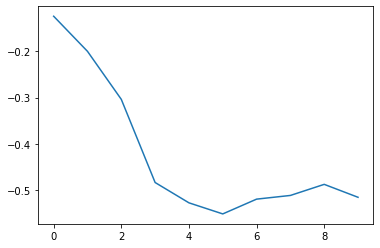

In [43]:
# Define variational circuit_variables
circuit_depth = 3
n_features = 2
n_labels = 1

intermediate_results = []

n_qubits = math.ceil(math.log2(n_features)) + n_labels

def seriessum(n):
    n_sum = 0
    for i in range(n):
        n_sum += i
    return n_sum

n_rot_qubits_per_layer = n_qubits * 2
n_qubits_per_layer = n_qubits * 2 + seriessum(n_qubits)
n_entangle_qubits_per_layer = seriessum(n_qubits)

param_size = circuit_depth * (n_rot_qubits_per_layer + n_entangle_qubits_per_layer)
total_runs = 0

def objective_function(params):
    global total_runs
    params.shape = (params.size // param_size, param_size)
    results = []
    tracked_inter_res = False
    
    total_runs += params.shape[0]
    for param_set in params:
        # construct circuit with given params
        qc = build_gan_stack(circuit_depth, n_features, n_labels, param_set)

        backend = Aer.get_backend('qasm_simulator')
        job = execute(backend=backend, experiments=qc, shots=500)
        counts = job.result().get_counts()

        result = 2 * counts['0'] / sum(counts.values()) - 1
        if not tracked_inter_res:
            print("Intermediate:", -result)
            print("total runs: ", total_runs)
            intermediate_results.append(-result)
            tracked_inter_res = True


        results.append(-result)
    
    return results
    
def generate_params(circuit_depth, n_features, n_labels):
    
    n_qubits = math.ceil(math.log2(n_features)) + n_labels

    def seriessum(n):
        n_sum = 0
        for i in range(n):
            n_sum += i
        return n_sum
    
    n_rot_qubits_per_layer = n_qubits * 2
    n_qubits_per_layer = n_qubits * 2 + seriessum(n_qubits)
    n_entangle_qubits_per_layer = seriessum(n_qubits)

    generated_params = np.random.rand(circuit_depth * (n_rot_qubits_per_layer + n_entangle_qubits_per_layer)) * math.pi
    
    return generated_params
    
init_params = generate_params(circuit_depth, n_features, n_labels)

print("Initial parameters:", init_params)
# objective_function(params)
    
# optimizer = COBYLA(maxiter=100)
optimizer = AQGD(maxiter=10)

ret = optimizer.optimize(num_vars=len(init_params), objective_function=objective_function, initial_point=init_params)

print("Supposed optimal parameters:", ret)

plt.plot(intermediate_results)
plt.show()


Initial parameters: [2.72217176 2.57425405 1.12623749 1.39577752 1.93575512 0.99657984
 1.2281393  0.97188462 0.82010401 1.73306643 0.79949907 1.21443506
 0.58320874 2.10902309 0.57041911 1.32971329 1.62167072 1.11369064
 2.81830497 0.04959751 2.13242447 2.20590801 1.87233461 1.80666349
 0.74685741 2.1205275  3.08417039]
Intermediate: 0.31200000000000006
total runs:  55
Intermediate: 0.45599999999999996
total runs:  110
Intermediate: 0.6319999999999999
total runs:  165
Intermediate: 0.7
total runs:  220
Intermediate: 0.796
total runs:  275
Intermediate: 0.8680000000000001
total runs:  330
Intermediate: 0.9239999999999999
total runs:  385
Intermediate: 0.956
total runs:  440
Intermediate: 0.984
total runs:  495
Intermediate: 0.964
total runs:  550
Intermediate: 0.968
total runs:  605
Intermediate: 0.968
total runs:  660
Intermediate: 0.992
total runs:  715
Intermediate: 0.984
total runs:  770
Intermediate: 0.988
total runs:  825
Intermediate: 0.996
total runs:  880
Intermediate: 0.976
t

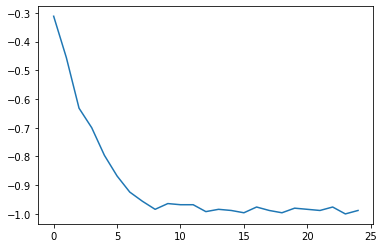

In [212]:
# Define variational circuit_variables
circuit_depth = 3
circuit_width = 3

intermediate_results = []

n_qubits = math.ceil(math.log2(n_features)) + n_labels

def seriessum(n):
    n_sum = 0
    for i in range(n):
        n_sum += i
    return n_sum

n_rot_qubits_per_layer = n_qubits * 2
n_qubits_per_layer = n_qubits * 2 + seriessum(n_qubits)
n_entangle_qubits_per_layer = seriessum(n_qubits)

param_size = circuit_depth * (n_rot_qubits_per_layer + n_entangle_qubits_per_layer)
total_runs = 0

def objective_function(params):
    global total_runs
    params.shape = (params.size // param_size, param_size)
    results = []
    tracked_inter_res = False
    
    total_runs += params.shape[0]
    for param_set in params:
        # construct circuit with given params
        qc = build_gan_stack_with_count(circuit_depth, param_set)

        backend = Aer.get_backend('qasm_simulator')
        job = execute(backend=backend, experiments=qc, shots=500)
        counts = job.result().get_counts()

        result = 2 * counts['0'] / sum(counts.values()) - 1
        if not tracked_inter_res:
            print("Intermediate:", result)
            print("total runs: ", total_runs)
            intermediate_results.append(-result)
            tracked_inter_res = True


        results.append(-result)
    
    return results
    
def generate_params(circuit_depth, circuit_width):
    
    n_qubits = circuit_width

    def seriessum(n):
        n_sum = 0
        for i in range(n):
            n_sum += i
        return n_sum
    
    n_rot_qubits_per_layer = n_qubits * 2
    n_qubits_per_layer = n_qubits * 2 + seriessum(n_qubits)
    n_entangle_qubits_per_layer = seriessum(n_qubits)

    generated_params = np.random.rand(circuit_depth * (n_rot_qubits_per_layer + n_entangle_qubits_per_layer)) * math.pi
    
    return generated_params
    
init_params = generate_params(circuit_depth, circuit_width)

print("Initial parameters:", init_params)
# objective_function(params)
    
# optimizer = COBYLA(maxiter=100)
optimizer = AQGD(maxiter=30)

ret = optimizer.optimize(num_vars=len(init_params), objective_function=objective_function, initial_point=init_params)

print("Supposed optimal parameters:", ret)

plt.plot(intermediate_results)
plt.show()


In [ ]:
params = init_params
num_params = len(params)
param_sets_to_eval = params + np.concatenate(
    (np.zeros((1, num_params)),  # copy of the parameters as is
     np.eye(num_params) * np.pi / 2,  # copy of the parameters with the positive shift
     -np.eye(num_params) * np.pi / 2),  # copy of the parameters with the negative shift
    axis=0)
# Evaluate,
# reshaping to flatten, as expected by objective function
values = np.array(objective_function(param_sets_to_eval.reshape(-1)))
print(params)
print(param_sets_to_eval.reshape(-1))
print(values)

In [48]:
def build_fake_stack(depth, n_features, n_labels, params=None):
    oracle, n_data_qubits, n_counting_qubits = construct_oracle(data, labels)
    generator,_,_ = construct_oracle(data, labels)
    
    oracle_gate = oracle.to_gate(label="oracle")
    generator_gate = generator.to_gate(label="generator")
    
    n_qubits = n_counting_qubits + n_data_qubits + generator.num_qubits + 2
    
    q = QuantumRegister(n_qubits)
    c = ClassicalRegister(1)
    qc = QuantumCircuit(q, c)
    
    swap_ancilla = q[:1]
    generator_qubits = q[1:generator.num_qubits + 1]
    generator_output_qubits = q[1:1 + n_data_qubits + 1]
    oracle_qubits = q[generator.num_qubits + 1:]
    oracle_output_qubits = q[generator.num_qubits + 1: generator.num_qubits + 1 + n_data_qubits]
    oracle_label_qubits = q[generator.num_qubits + 1 + n_data_qubits:generator.num_qubits + 1 + n_data_qubits + 1]

    oracle_counting_qubits = q[generator.num_qubits + 1 + n_data_qubits + 1:]
    
    qc.append(generator_gate, generator_qubits)
    qc.append(oracle_gate, oracle_qubits)
    
    swap_test_gate = swap(n_data_qubits + 1)
    swap_test_qubits = swap_ancilla + generator_output_qubits + oracle_output_qubits + oracle_label_qubits
#     print(len(generator_output_qubits), len(oracle_output_qubits), len(oracle_label_qubits))
    
    qc.append(swap_test_gate, swap_test_qubits)
    
    qc.measure(0, 0)
    
    return qc

qc = build_fake_stack(8, 2, 1)

backend = Aer.get_backend('qasm_simulator')
job = execute(backend=backend, experiments=qc, shots=500)
counts = job.result().get_counts()

result = 2 * counts['0'] / sum(counts.values()) - 1

print(result)

0.42399999999999993


In [167]:
oracle1, n_data_qubits, n_counting_qubits = construct_oracle(data, labels)
oracle2, n_data_qubits, n_counting_qubits = construct_oracle(data, labels)

print(oracle1)
oracle_gate_1 = oracle1.to_gate()
oracle_gate_2 = oracle1.to_gate()

q = QuantumRegister((n_data_qubits + n_counting_qubits + 1) * 2 + 1)
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)

ancilla = q[0:1]

current = 1
oracle_1_data = q[1:n_data_qubits + 1]
oracle_1_label = q[n_data_qubits + 1:n_data_qubits + 2]
oracle_1_counting = q[n_data_qubits + 2:n_data_qubits + 2 + n_counting_qubits]

current = n_data_qubits + 2 + n_counting_qubits
oracle_2_data = q[current:n_data_qubits + current]
oracle_2_label = q[n_data_qubits + current:n_data_qubits + 1 + current]
oracle_2_counting = q[n_data_qubits + 1 + current:n_data_qubits + 1 + current + n_counting_qubits]

print(len(oracle_1_data), len(oracle_1_label), len(oracle_1_counting))
print(len(oracle_2_data), len(oracle_2_label), len(oracle_2_counting))
print(n_counting_qubits)
qc.append(oracle_gate_1, oracle_1_data + oracle_1_label + oracle_1_counting)
qc.append(oracle_gate_2, oracle_2_data + oracle_2_label + oracle_2_counting)

swap_test_gate = swap(1)

qc.append(swap_test_gate, ancilla + oracle_1_data + oracle_2_data)

qc.measure(0,0)
print(qc)
backend = Aer.get_backend('qasm_simulator')
job = execute(backend=backend, experiments=qc, shots=10000)
counts = job.result().get_counts()

result = 2 * counts['0'] / sum(counts.values()) - 1

print(result)

                     ┌───────┐          ┌───────┐          ┌───────┐          »
q636618_0: ──────────┤ psi_0 ├──────────┤ psi_1 ├──────────┤ psi_2 ├──────────»
                     └───┬───┘          └───┬───┘          └───┬───┘          »
q636618_1: ──────────────┼──────────────────┼──────────────────┼──────────────»
           ┌───┐┌───┐    │    ┌───┐         │    ┌───┐         │    ┌───┐     »
q636618_2: ┤ H ├┤ X ├────■────┤ X ├─────────■────┤ X ├─────────■────┤ X ├─────»
           ├───┤├───┤    │    ├───┤┌───┐    │    ├───┤         │    └───┘     »
q636618_3: ┤ H ├┤ X ├────■────┤ X ├┤ X ├────■────┤ X ├─────────■──────────────»
           ├───┤├───┤    │    ├───┤├───┤    │    ├───┤┌───┐    │    ┌───┐┌───┐»
q636618_4: ┤ H ├┤ X ├────■────┤ X ├┤ X ├────■────┤ X ├┤ X ├────■────┤ X ├┤ X ├»
           └───┘└───┘         └───┘└───┘         └───┘└───┘         └───┘└───┘»
«           ┌───────┐     ┌───────┐               ┌───────┐          ┌───────┐»
«q636618_0: ┤ psi_3 ├─────┤ psi_4 ├─────

In [100]:
oracle1, n_data_qubits, n_counting_qubits = construct_oracle(data, labels)
oracle2, n_data_qubits, n_counting_qubits = construct_oracle(data, labels)

print(oracle1)
oracle_gate_1 = oracle1.to_gate()
oracle_gate_2 = oracle1.to_gate()

q = QuantumRegister((n_data_qubits + n_counting_qubits + 1) * 2 + 1)
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)

ancilla = q[0:1]

current = 1
oracle_1_data = q[1:n_data_qubits + 1]
oracle_1_label = q[n_data_qubits + 1:n_data_qubits + 2]
oracle_1_counting = q[n_data_qubits + 2:n_data_qubits + 2 + n_counting_qubits]

current = n_data_qubits + 2 + n_counting_qubits
oracle_2_data = q[current:n_data_qubits + current]
oracle_2_label = q[n_data_qubits + current:n_data_qubits + 1 + current]
oracle_2_counting = q[n_data_qubits + 1 + current:n_data_qubits + 1 + current + n_counting_qubits]

print(len(oracle_1_data), len(oracle_1_label), len(oracle_1_counting))
print(len(oracle_2_data), len(oracle_2_label), len(oracle_2_counting))
print(n_counting_qubits)
# qc.append(oracle_gate_1, oracle_1_data + oracle_1_label + oracle_1_counting)
# qc.append(oracle_gate_2, oracle_2_data + oracle_2_label + oracle_2_counting)

swap_test_gate = swap(1)

qc.append(swap_test_gate, ancilla + q[1:3])

qc.measure(7,0)
print(qc)
backend = Aer.get_backend('qasm_simulator')
job = execute(backend=backend, experiments=qc, shots=10000)
counts = job.result().get_counts()

result = 2 * counts['0'] / sum(counts.values()) - 1

print(result)

                     ┌───────┐          ┌───────┐          ┌───────┐          »
q633734_0: ──────────┤ psi_0 ├──────────┤ psi_1 ├──────────┤ psi_2 ├──────────»
                     └───┬───┘          └───┬───┘          └───┬───┘          »
q633734_1: ──────────────┼──────────────────┼──────────────────┼──────────────»
           ┌───┐┌───┐    │    ┌───┐         │    ┌───┐         │    ┌───┐     »
q633734_2: ┤ H ├┤ X ├────■────┤ X ├─────────■────┤ X ├─────────■────┤ X ├─────»
           ├───┤├───┤    │    ├───┤┌───┐    │    ├───┤         │    └───┘     »
q633734_3: ┤ H ├┤ X ├────■────┤ X ├┤ X ├────■────┤ X ├─────────■──────────────»
           ├───┤├───┤    │    ├───┤├───┤    │    ├───┤┌───┐    │    ┌───┐┌───┐»
q633734_4: ┤ H ├┤ X ├────■────┤ X ├┤ X ├────■────┤ X ├┤ X ├────■────┤ X ├┤ X ├»
           └───┘└───┘         └───┘└───┘         └───┘└───┘         └───┘└───┘»
«           ┌───────┐     ┌───────┐               ┌───────┐          ┌───────┐»
«q633734_0: ┤ psi_3 ├─────┤ psi_4 ├─────

In [147]:
oracle1, n_data_qubits, n_counting_qubits = construct_oracle(data, labels)
oracle2, n_data_qubits, n_counting_qubits = construct_oracle(data, labels)

print(oracle1)
oracle_gate_1 = oracle1.to_gate(label="oracle")
oracle_gate_2 = oracle1.to_gate()

q = QuantumRegister((n_data_qubits + n_counting_qubits + 1))
c = ClassicalRegister(1)
qc = QuantumCircuit(q)

# ancilla = q[0:1]

current = 0
oracle_1_data = q[current:n_data_qubits + current]
oracle_1_label = q[n_data_qubits + current:n_data_qubits + current + 1]
oracle_1_counting = q[n_data_qubits + current + 1:n_data_qubits + current + 1 + n_counting_qubits]

print(len(oracle_1_data), len(oracle_1_label), len(oracle_1_counting))

qc.append(oracle_gate_1, oracle_1_data + oracle_1_label + oracle_1_counting)
# qc.append(oracle_gate_2, oracle_2_data + oracle_2_label + oracle_2_counting)

print(qc)
simulator = Aer.get_backend('statevector_simulator')
circ = transpile(qc, simulator)

# Run and get statevector
result = simulator.run(circ).result()
statevector = result.get_statevector(circ)

# result = 2 * counts['0'] / sum(counts.values()) - 1
def state_prop(s):
    return s.real ** 2 + s.imag ** 2
    
total = 0
for i in range(8):
    
    base = i + (8 if i < 4 else 0)
    prob = state_prop(statevector[base]) + state_prop(statevector[base + 16])
    
    total += prob

print(total)
    

# print(sum([val.real ** 2 + val.imag ** 2 for val in statevector]))
# print(statevector)
val1 = statevector[int('00000',2)]
val2 = statevector[int('00000',2)]

prob1 = val1.real ** 2 + val1.imag ** 2
prob2 = val2.real ** 2 + val2.imag ** 2
print(prob1, prob2)

                     ┌───────┐          ┌───────┐          ┌───────┐          »
q636370_0: ──────────┤ psi_0 ├──────────┤ psi_1 ├──────────┤ psi_2 ├──────────»
                     └───┬───┘          └───┬───┘          └───┬───┘          »
q636370_1: ──────────────┼──────────────────┼──────────────────┼──────────────»
           ┌───┐┌───┐    │    ┌───┐         │    ┌───┐         │    ┌───┐     »
q636370_2: ┤ H ├┤ X ├────■────┤ X ├─────────■────┤ X ├─────────■────┤ X ├─────»
           ├───┤├───┤    │    ├───┤┌───┐    │    ├───┤         │    └───┘     »
q636370_3: ┤ H ├┤ X ├────■────┤ X ├┤ X ├────■────┤ X ├─────────■──────────────»
           ├───┤├───┤    │    ├───┤├───┤    │    ├───┤┌───┐    │    ┌───┐┌───┐»
q636370_4: ┤ H ├┤ X ├────■────┤ X ├┤ X ├────■────┤ X ├┤ X ├────■────┤ X ├┤ X ├»
           └───┘└───┘         └───┘└───┘         └───┘└───┘         └───┘└───┘»
«           ┌───────┐     ┌───────┐               ┌───────┐          ┌───────┐»
«q636370_0: ┤ psi_3 ├─────┤ psi_4 ├─────

In [166]:
q = QuantumRegister(5)
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)

qc.h(q[1])
qc.h(q[3])

qc.cx(q[1], q[2])
qc.cx(q[3], q[4])

qc.append(swap(2),q)
# qc.barrier()
# qc.h(q[0])

# qc.cswap(q[0], q[2], q[4])

# qc.h(q[0])


qc.measure(0,0)
print(qc)
backend = Aer.get_backend('aer_simulator')
job = execute(backend=backend, experiments=qc, shots=10000)
counts = job.result().get_counts()


print(counts)

                     ┌───────┐┌─┐
q636602_0: ──────────┤0      ├┤M├
           ┌───┐     │       │└╥┘
q636602_1: ┤ H ├──■──┤1      ├─╫─
           └───┘┌─┴─┐│       │ ║ 
q636602_2: ─────┤ X ├┤2 swap ├─╫─
           ┌───┐└───┘│       │ ║ 
q636602_3: ┤ H ├──■──┤3      ├─╫─
           └───┘┌─┴─┐│       │ ║ 
q636602_4: ─────┤ X ├┤4      ├─╫─
                └───┘└───────┘ ║ 
 c10181: 1/════════════════════╩═
                               0 
{'0': 10000}
